Aim: Create a representation of a DNA construction
    . Create outline
    . Add features
    . Associate info to features

To test the code in the future, it will be used an example that can be found on https://github.com/BjornFJohansson/pydna-examples/blob/master/assembly/assembly.ipynb

In [1]:
from pydna import *

In [40]:
b  = Dseqrecord("agctactgactattaggggttattctgatcatctgatctactatctgactgtactgatcta")
l  = Dseqrecord("AGGCATCTACTG")
c  = Dseqrecord("tctgatctactatctgactgtactgatctattgacactgtgatcattctagtgtattactc")
(b+l+c).looped().cseguid()



frags = assembly_fragments( (primer_design(b), l, primer_design(c), primer_design(b)), 1)

b2 = pcr(frags[-1].forward_primer, frags[0].reverse_primer, b)

asm2 = Assembly( (b2, frags[1]), limit=1, only_terminal_overlaps=True)

asm2.circular_products[0]

Contig(o134)

It will be tried a circular representation 

In [3]:
class MyCircle(object):

    def __init__(self, center=(0.0,0.0), radius=200.0, color='blue'):
        self.center = center
        self.radius = radius
        self.color = color
        
    def _repr_html_(self):
        return "&#x25CB; (<b>html</b>)"

    def _repr_svg_(self):
        return """<svg width="100px" height="100px">
           <circle cx="50" cy="50" r="20" stroke="black" stroke-width="1" fill="blue"/>
        </svg>"""
    
    def _repr_latex_(self):
        return r"$\bigcirc \LaTeX$"

    def _repr_javascript_(self):
        from IPython.display import display_html
        html='''<html>
                  <head>Circle representation</head>
                  <body>
                    <canvas id='mycircle'></canvas>
                  </body>
               </html>'''
        display_html(html, raw=True)
        
        js='''var radius = {};
        var c = document.getElementById("mycircle");
        var ctx = c.getContext("2d");
        ctx.canvas.width  = radius*2+200;
        ctx.canvas.height = radius*2+200;
        ctx.beginPath();
        ctx.lineWidth = 50;
        ctx.arc(300, 300, radius, 0, (2/3)*Math.PI);
        ctx.strokeStyle = "red";
        ctx.stroke();
        ctx.beginPath();
        ctx.arc(300, 300, radius, (2/3)*Math.PI, (4/3) * Math.PI);
        ctx.strokeStyle = "blue";
        ctx.stroke();
        ctx.beginPath();
        ctx.arc(300, 300, radius, (4/3)*Math.PI, 2 * Math.PI-0.01);
        ctx.strokeStyle = "yellow";
        ctx.stroke();
        ctx.beginPath();
        ctx.arc(300, 300, radius, 2 * Math.PI-0.01, 2 * Math.PI);
        ctx.strokeStyle = "green";
        ctx.stroke()'''.format(self.radius)

        return js

Circle representation

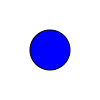

In [4]:
mc = MyCircle(radius = 200)
mc

The smaller fragments can be hard to represent, cause in a circle proportions take an important role (green portion as example)

In [5]:
class Box(object):

    def __init__(self, center=(0.0,0.0), width = 500, heigth = 300, color='blue'):
        self.center = center
        self.color = color
        self.width = width
        self.heigth = heigth
        
    def _repr_html_(self):
        return "&#x25CB; (<b>html</b>)"
    
    def _repr_javascript_(self):
        from IPython.display import display_html
        html='''<html>
                  <head></head>
                  <body>
                    <canvas id='myRepr'></canvas>
                  </body>
               </html>'''
        display_html(html, raw=True)
        
        js='''var R_width = {};
        var R_heigth = {};
        var c = document.getElementById("myRepr");
        var ctx = c.getContext("2d");
        ctx.canvas.width  = R_width+100;
        ctx.canvas.height = R_heigth+100;
        ctx.rect(50, 30, R_width, R_heigth);
        ctx.lineWidth = 10;
        ctx.strokeStyle = "red";
        ctx.stroke()'''.format(self.width, self.heigth)

        return js

In [6]:
B = Box()
B

On a rectangle, proportions take a secondary role (visually) so the code will be developed to represent the construction in that structure.

Although, with the method used above, the colors can't be used the way we want to use them

The following code will draw a path organized on a rectangular structure, it will allow us to assign colors to each part of the construction and it will probably be easier to interact with them

In [35]:
class Box_and_lines(object):

    def __init__(self, center=(0.0,0.0), width = 500, heigth = 200, color='blue'):
        self.center = center
        self.color = color
        self.width = width
        self.heigth = heigth
        
    def _repr_html_(self):
        return "&#x25CB; (<b>html</b>)"
    
    def _repr_javascript_(self):
        from IPython.display import display_html
        html='''<html>
                  <head></head>
                  <body>
                    <canvas id='myBL'></canvas>
                  </body>
               </html>'''
        display_html(html, raw=True)
        
        js='''var R_width = {};
        var R_heigth = {};
        var c = document.getElementById("myBL");
        var ctx = c.getContext("2d");
        ctx.canvas.width  = R_width+100;
        ctx.canvas.height = R_heigth+100;
        ctx.beginPath();
        ctx.moveTo(20,20);
        ctx.lineWidth = 20;
        ctx.lineTo(94,20);
        ctx.strokeStyle = "yellow";
        ctx.stroke();
        ctx.beginPath();
        ctx.moveTo(94,60);
        ctx.lineTo(217,60);
        ctx.strokeStyle="red";
        ctx.stroke()'''.format(self.width, self.heigth)

        return js

In [36]:
C = Box_and_lines()
C

In [152]:
class Product_repr(object):

    def __init__(self, product, width = 1000, heigth = 500):
        self.prod = product
        self.width = width
        self.heigth = heigth
        self.frag_list = product.source_fragments
        self.frag_N = product.number_of_fragments
        self.fragment_width = 175
        self.fragment_heigth = 45
        self.overlap_width = 35
        
    def _repr_html_(self):
        return "&#x25CB; (<b>html</b>)"
    
    def _repr_javascript_(self):
        from IPython.display import display_html
        html='''<html>
                  <head></head>
                  <body>
                    <canvas id='Prod'></canvas>
                  </body>
               </html>'''
        display_html(html, raw=True)
        
        return self.get_js()
    
    def get_js(self):
        begin_x = 65
        middle_y = 80
        delta_y = self.fragment_heigth + 10
        end_x = begin_x + self.fragment_width
        js = '''
        var c = document.getElementById('Prod');
        var ctx = c.getContext('2d');
        ctx.canvas.width  = {W};
        ctx.canvas.height = {H};
        var start_x = {S};
        var mid_y = {Y};
        var delta_y = {D};
        var end_x = {E};
        var ovr = {O};
        
        ctx.beginPath();
        ctx.moveTo(start_x, mid_y - delta_y);
        ctx.lineWidth = {L};
        ctx.lineTo(end_x, mid_y - delta_y);
        ctx.strokeStyle = "yellow";
        ctx.stroke();
        ctx.beginPath();
        ctx.moveTo(end_x, mid_y - delta_y);
        ctx.lineTo(end_x + ovr, mid_y - delta_y);
        ctx.strokeStyle = "red";
        ctx.stroke();;
        '''.format(W = self.width,
                   H = self.heigth,
                   S = begin_x,
                   Y = middle_y,
                   D = delta_y,
                   E = end_x,
                   O = self.overlap_width,
                   L = self.fragment_heigth)
        start_x = end_x + self.overlap_width
        
        for Frag in range(1, self.frag_N):
            end_x = start_x + self.fragment_width
            new_js='''
            start_x = {s};
            end_x = {e};
            ctx.beginPath();
            ctx.moveTo(start_x - ovr, mid_y -(Math.pow(-1,{n})*delta_y));
            ctx.lineTo(start_x, mid_y -(Math.pow(-1,{n})*delta_y));
            ctx.strokeStyle = "red";
            ctx.stroke();
            ctx.beginPath();
            ctx.moveTo(start_x, mid_y -(Math.pow(-1,{n})*delta_y));
            ctx.lineTo(end_x, mid_y -(Math.pow(-1,{n})*delta_y));
            ctx.strokeStyle = "yellow";
            ctx.stroke();
            ctx.beginPath();
            ctx.moveTo(end_x, mid_y -(Math.pow(-1,{n})*delta_y));
            ctx.lineTo(end_x + ovr, mid_y -(Math.pow(-1,{n})*delta_y));
            ctx.strokeStyle = "red";
            ctx.stroke();
            '''.format(s = start_x,
                       e = end_x,
                       n = Frag)
            start_x = end_x + self.overlap_width
            
            js = js + new_js
            
        if not self.prod.linear:
            js = js + '''
            ctx.beginPath();
            ctx.moveTo({s}, mid_y -(Math.pow(-1,{n})*delta_y));
            ctx.lineWidth = ctx.lineWidth/5;
            ctx.lineTo({s} + 20, mid_y -(Math.pow(-1,{n})*delta_y));
            ctx.lineTo({s} + 20, mid_y -(Math.pow(-1,{n})*delta_y) + 250);
            ctx.lineTo({b}-55, mid_y -(Math.pow(-1,{n})*delta_y) + 250);
            ctx.lineTo({b}-55, mid_y - delta_y);
            ctx.lineTo({b}-35, mid_y - delta_y);
            ctx.strokeStyle = "blue";
            ctx.stroke();
            ctx.beginPath();
            ctx.moveTo({b}-35, mid_y - delta_y);
            ctx.lineTo({b}, mid_y - delta_y);
            ctx.lineWidth = ctx.lineWidth*5;
            ctx.strokeStyle = "red";
            ctx.stroke();
            '''.format(s = start_x,
                       n = len(self.frag_list)-1,
                       b = begin_x)
                       
            
            
        return js

In [153]:
D = Product_repr(asm2.circular_products[0])
D

Notes!!!

In [ ]:
js="""function getMousePos(canvas, event) {
	var rect = canvas.getBoundingClientRect();
	return {
		x: event.clientX - rect.left,
		y: event.clientY - rect.top
	};
}
function isInside(pos, rect){
	return pos.x > rect.x && pos.x < rect.x+rect.width && pos.y < rect.y+rect.heigth && pos.y > rect.y
}

var canvas = document.getElementById('myCanvas');
var context = canvas.getContext('2d');
var rect = {
	x:250,
	y:350,
	width:200,
	heigth:100
};

canvas.addEventListener('click', function(evt) {
	var mousePos = getMousePos(canvas, evt);
    debugger;
	if (isInside(mousePos,rect)) {
		alert('clicked inside rect');
    }else{
        alert('clicked outside rect');
    }	
}, false);

context.beginPath();
context.rect(250, 350, 200, 100); 
context.fillStyle = '#FFFFFF'; 
context.fillStyle = 'rgba(225,225,225,0.5)';
context.fillRect(25,72,32,32);
context.fill(); 
context.lineWidth = 2;
context.strokeStyle = '#000000'; 
context.stroke();
context.closePath();
context.font = '40pt Kremlin Pro Web';
context.fillStyle = '#000000';
context.fillText('Start', 345, 415);"""